In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
file_path = "data/healthcare-dataset-stroke-data.csv"

df = pd.read_csv(file_path)

In [4]:
# Configuracion general de graficos
sns.set(style="whitegrid", palette="deep", context="notebook")
plt.rcParams["figure.figsize"] = (10, 6)

In [5]:
print("Dimensiones del dataset:", df.shape)
print("\nPrimeras filas:")
display(df.head())

print("\nInformación general:")
df.info()

print("\nValores faltantes por columna:")
print(df.isna().sum())

Dimensiones del dataset: (5110, 12)

Primeras filas:


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1



Información general:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB

Valores faltantes por columna:
id                     0
gender                 0
age                    0
hypertension           0
hea

In [6]:
df['bmi'] = df['bmi'].replace('N/A', np.nan).astype(float)

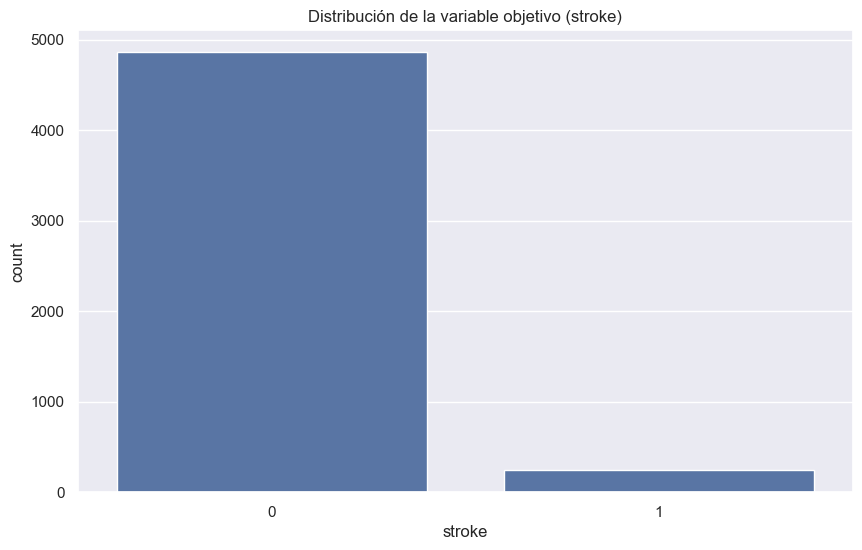

In [7]:
sns.countplot(x='stroke', data=df)
plt.title('Distribución de la variable objetivo (stroke)')
plt.show()

### Distribucion de edad, nivel de glucosa y BMI


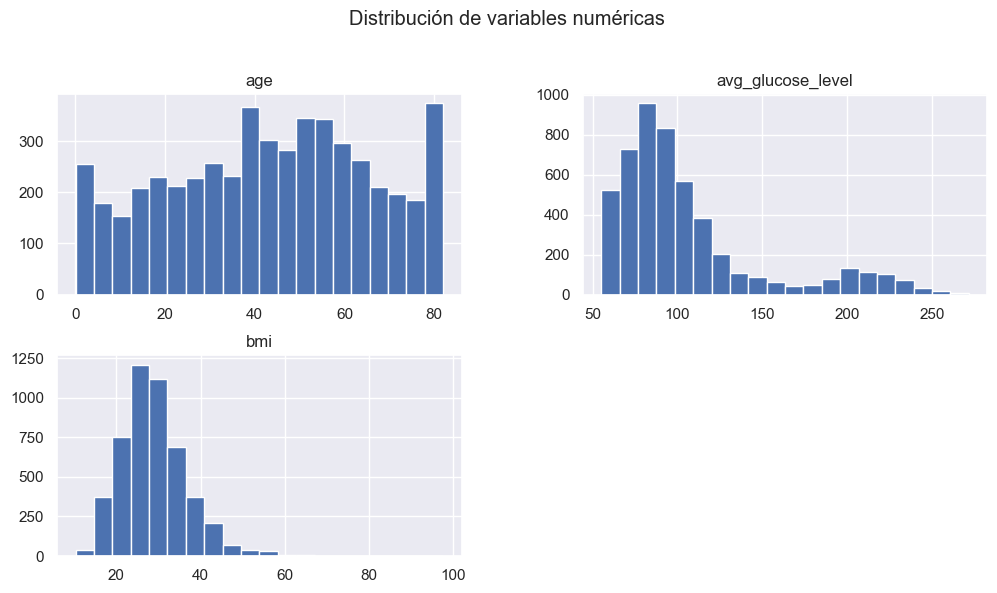

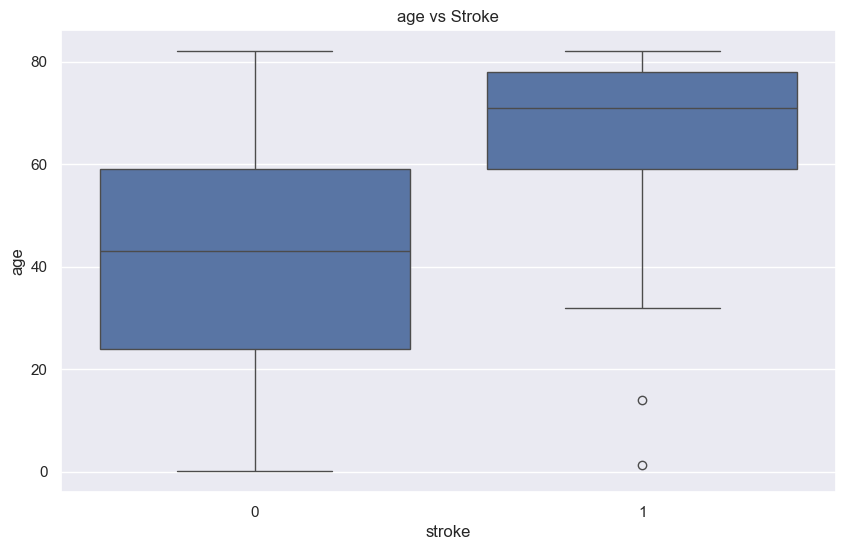

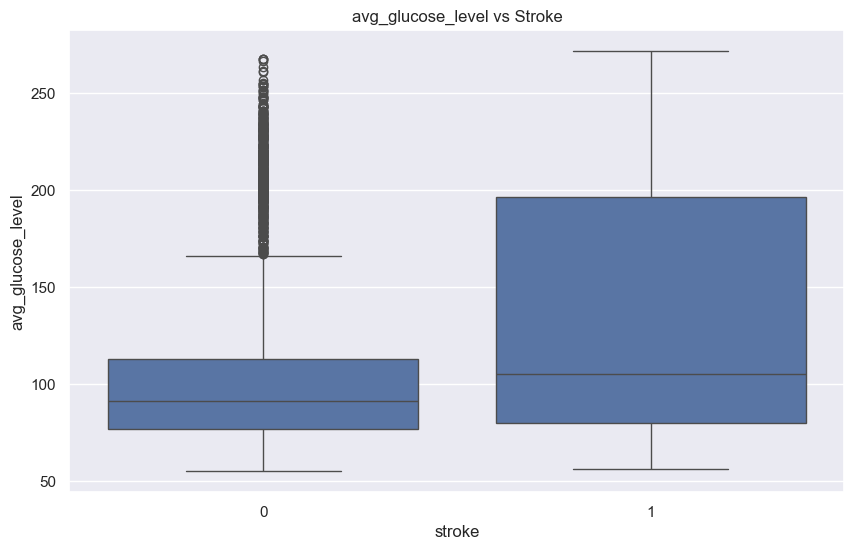

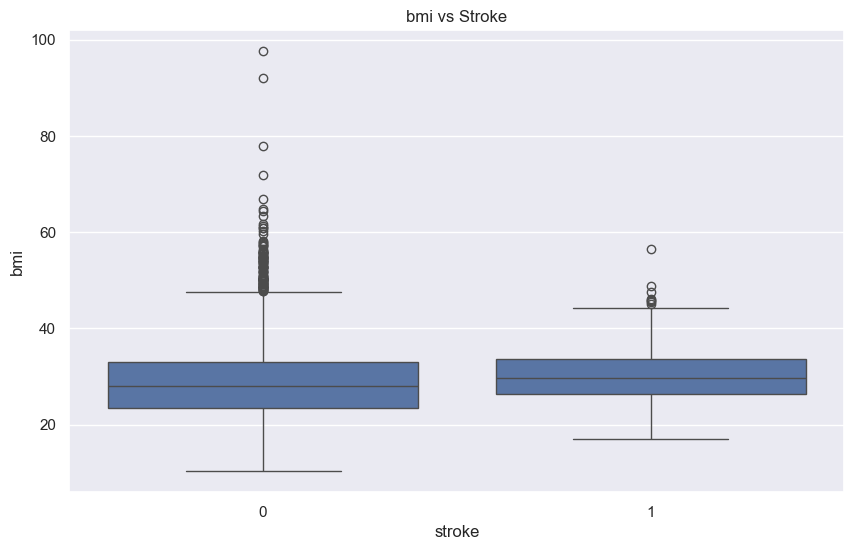

In [8]:
num_vars = ['age', 'avg_glucose_level', 'bmi']
df[num_vars].hist(bins=20, figsize=(12, 6))
plt.suptitle('Distribución de variables numéricas', y=1.02)
plt.show()

# comparanmos stroke vs variables numericas
for col in num_vars:
    sns.boxplot(x='stroke', y=col, data=df)
    plt.title(f'{col} vs Stroke')
    plt.show()

### Matriz de correlacion entre variables numericas

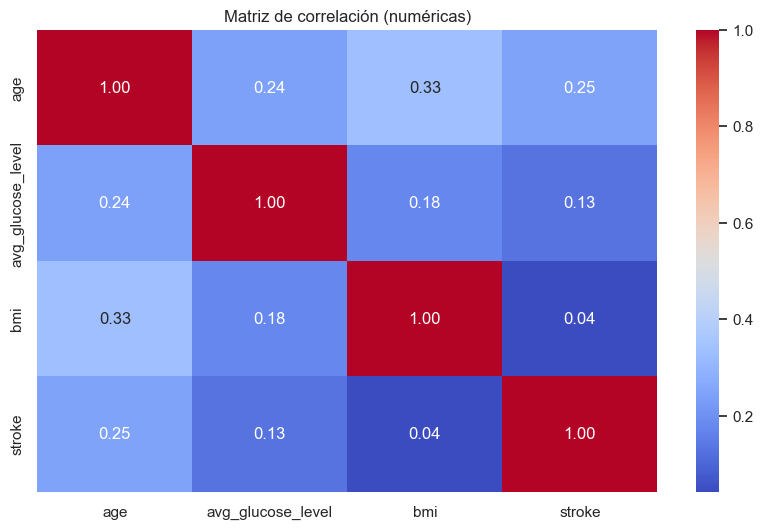

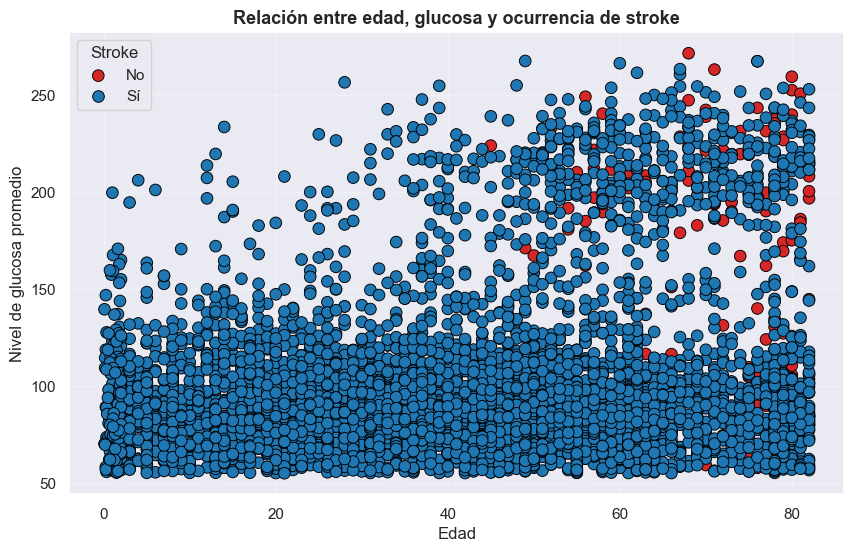

In [12]:
corr = df[num_vars + ['stroke']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de correlación (numéricas)')
plt.show()

# Relacion entre edad y nivel de glucosa, coloreado por stroke
sns.scatterplot(
    data=df,
    x='age',
    y='avg_glucose_level',
    hue='stroke',
    palette={0: '#1f77b4', 1: '#d62728'},  # azul fuerte para 0, rojo intenso para 1
    alpha=1,
    edgecolor='black',
    s=70  # tamaño de puntos
)
plt.title('Relación entre edad, glucosa y ocurrencia de stroke', fontsize=13, weight='bold')
plt.xlabel('Edad')
plt.ylabel('Nivel de glucosa promedio')
plt.legend(title='Stroke', labels=['No', 'Sí'])
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

### Distribuciones categoricas vs Target

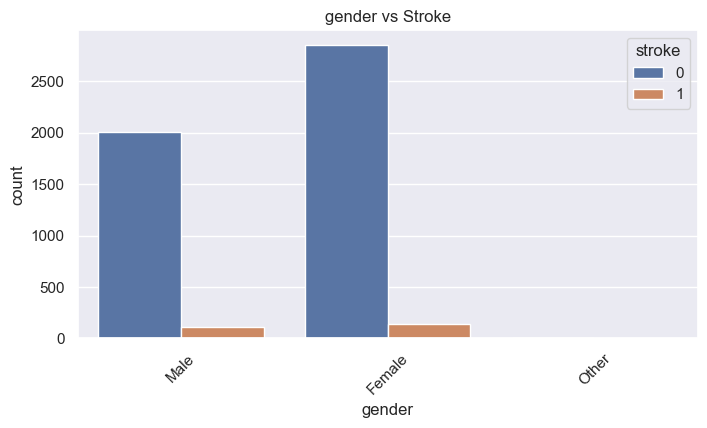

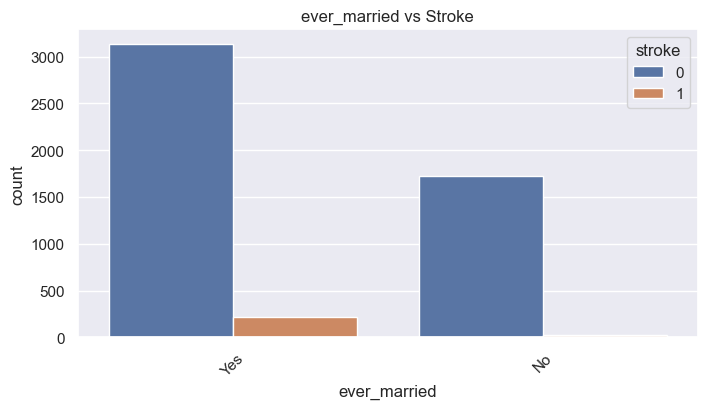

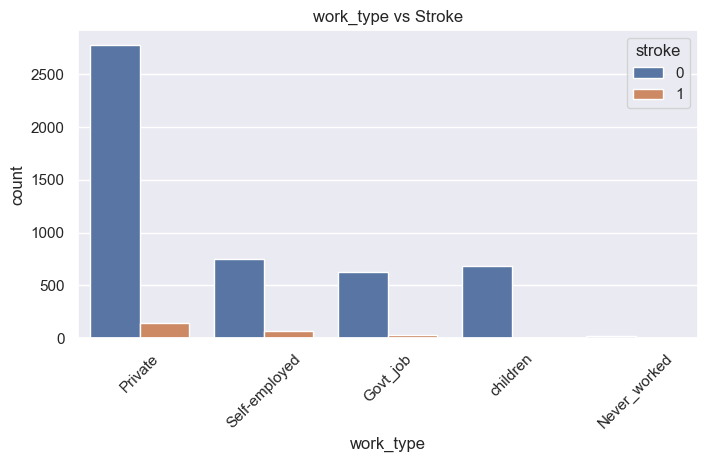

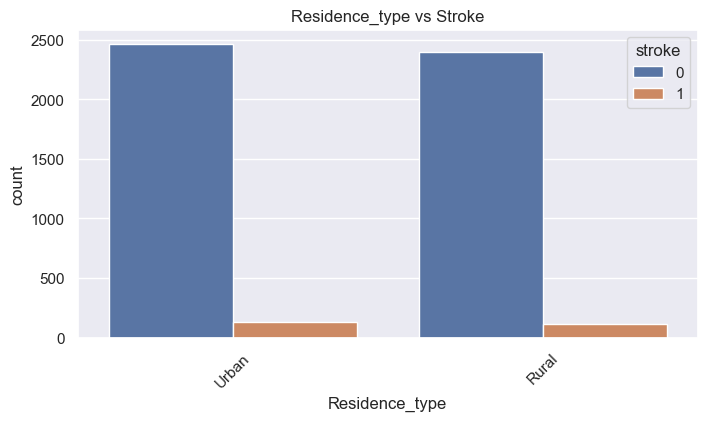

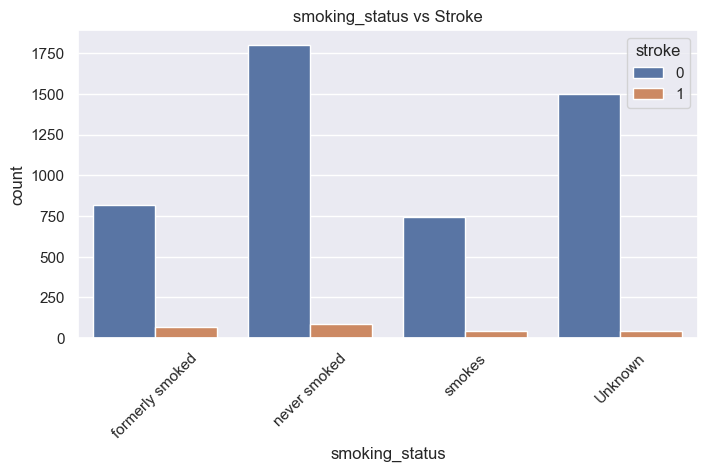

In [10]:
categorical_vars = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
for col in categorical_vars:
    plt.figure(figsize=(8,4))
    sns.countplot(data=df, x=col, hue='stroke')
    plt.title(f'{col} vs Stroke')
    plt.xticks(rotation=45)
    plt.show()